# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
import pandas as pd
from catboost import CatBoostRegressor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
from lightgbm import LGBMRegressor
from scipy import stats
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import percentileofscore

In [2]:
autos = pd.read_csv('/datasets/autos.csv')
autos.sample(n=5,random_state=12345)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
18734,2016-04-04 13:36:58,16900,bus,2010,auto,150,viano,150000,4,gasoline,mercedes_benz,no,2016-04-04 00:00:00,0,60326,2016-04-05 12:18:31
141787,2016-03-07 17:57:08,15500,other,2011,manual,143,1er,40000,5,gasoline,bmw,no,2016-03-07 00:00:00,0,35083,2016-04-06 20:19:15
37523,2016-03-24 09:37:02,3600,sedan,2004,manual,125,astra,150000,12,petrol,opel,no,2016-03-24 00:00:00,0,13627,2016-03-24 10:38:57
194192,2016-03-15 09:49:03,8990,sedan,2007,auto,224,c_klasse,150000,9,gasoline,mercedes_benz,no,2016-03-15 00:00:00,0,58135,2016-03-18 02:17:06
110210,2016-03-29 23:43:52,2500,other,1994,manual,68,transporter,150000,9,gasoline,volkswagen,no,2016-03-29 00:00:00,0,24598,2016-04-02 12:45:46


In [3]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [4]:
autos.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В нашей таблице есть такие выпады, как 9999 год и мощность 0 л/с, учтём это при отборе данных.

In [5]:
autos['DateCrawled'] = pd.to_datetime(autos['DateCrawled'], format='%Y-%m-%dT%H:%M:%S')
autos['DateCreated'] = pd.to_datetime(autos['DateCreated'], format='%Y-%m-%dT%H:%M:%S')
autos['LastSeen'] = pd.to_datetime(autos['LastSeen'], format='%Y-%m-%dT%H:%M:%S')
autos=autos.drop('NumberOfPictures', axis=1)

In [6]:
for i in ['VehicleType','Gearbox','FuelType','Brand','NotRepaired','Model']:
    display(i)
    print(autos[i].unique())

'VehicleType'

[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']


'Gearbox'

['manual' 'auto' nan]


'FuelType'

['petrol' 'gasoline' nan 'lpg' 'other' 'hybrid' 'cng' 'electric']


'Brand'

['volkswagen' 'audi' 'jeep' 'skoda' 'bmw' 'peugeot' 'ford' 'mazda'
 'nissan' 'renault' 'mercedes_benz' 'opel' 'seat' 'citroen' 'honda' 'fiat'
 'mini' 'smart' 'hyundai' 'sonstige_autos' 'alfa_romeo' 'subaru' 'volvo'
 'mitsubishi' 'kia' 'suzuki' 'lancia' 'toyota' 'chevrolet' 'dacia'
 'daihatsu' 'trabant' 'saab' 'chrysler' 'jaguar' 'daewoo' 'porsche'
 'rover' 'land_rover' 'lada']


'NotRepaired'

[nan 'yes' 'no']


'Model'

['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spider' 'cuore' 's_max' 'a2' 'galaxy' 'c3' 'viano' 's_klasse'
 '1_reihe' 'avensis' 'roomster' 'sl' 'kaefer' 'santa' 'cooper' 'leon'
 '4

Привели типы к нужным, определили категориальные признаки.

In [7]:
autos['NotRepaired']=autos['NotRepaired'].fillna('no')

Заполнили пропуски в отзывной компании значениями "нет".

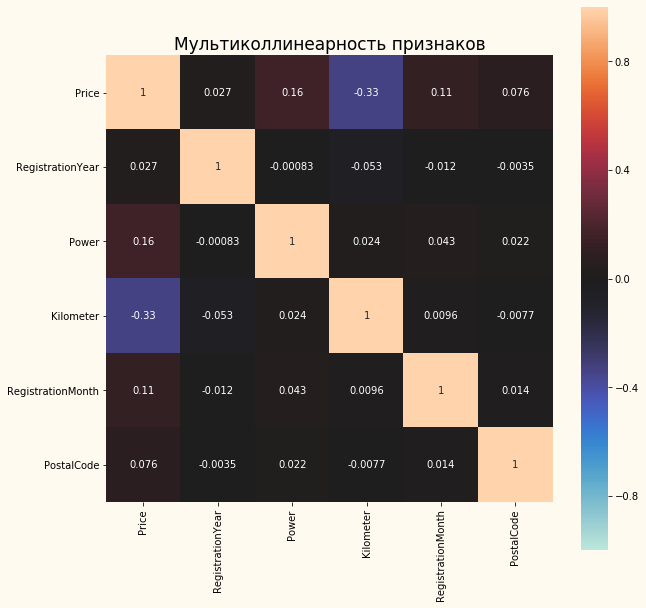

In [8]:
fig, ax = plt.subplots()
sns.heatmap(autos.corr(),vmin=-1, vmax=1, center= 0,square=True,annot=True)
ax.set_facecolor('seashell')
fig.set_figwidth(10)
fig.set_figheight(10)
fig.set_facecolor('floralwhite')
plt.title('Мультиколлинеарность признаков', fontsize=17)
plt.show()

Проверили коллениарность признаков.

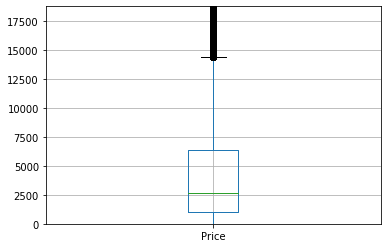

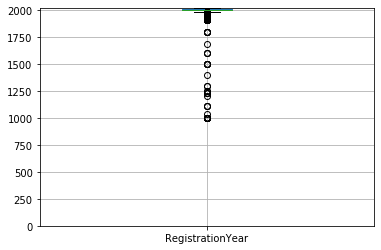

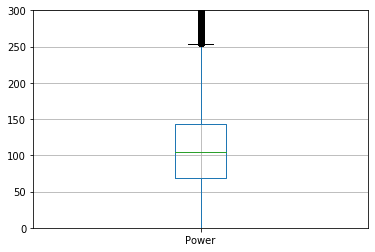

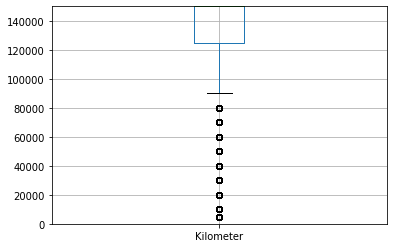

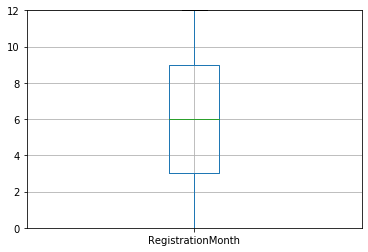

In [9]:
for i in ['Price','RegistrationYear','Power','Kilometer','RegistrationMonth']:
    autos.boxplot(column=i)
    plt.ylim(0,autos[i].quantile(0.99))
    plt.show()

In [10]:
autos[['VehicleType','Gearbox','FuelType','Brand','NotRepaired','Model']]=autos[['VehicleType','Gearbox','FuelType','Brand','NotRepaired','Model']].fillna(value='not_listed')
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
DateCrawled          354369 non-null datetime64[ns]
Price                354369 non-null int64
VehicleType          354369 non-null object
RegistrationYear     354369 non-null int64
Gearbox              354369 non-null object
Power                354369 non-null int64
Model                354369 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             354369 non-null object
Brand                354369 non-null object
NotRepaired          354369 non-null object
DateCreated          354369 non-null datetime64[ns]
PostalCode           354369 non-null int64
LastSeen             354369 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(6), object(6)
memory usage: 40.6+ MB


In [11]:
autos_clear=autos.query('RegistrationYear>1900 & RegistrationYear<2021 & Power>50 & Power<500')
autos_clear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303046 entries, 1 to 354368
Data columns (total 15 columns):
DateCrawled          303046 non-null datetime64[ns]
Price                303046 non-null int64
VehicleType          303046 non-null object
RegistrationYear     303046 non-null int64
Gearbox              303046 non-null object
Power                303046 non-null int64
Model                303046 non-null object
Kilometer            303046 non-null int64
RegistrationMonth    303046 non-null int64
FuelType             303046 non-null object
Brand                303046 non-null object
NotRepaired          303046 non-null object
DateCreated          303046 non-null datetime64[ns]
PostalCode           303046 non-null int64
LastSeen             303046 non-null datetime64[ns]
dtypes: datetime64[ns](3), int64(6), object(6)
memory usage: 37.0+ MB


In [12]:
autos_clear=pd.get_dummies(autos_clear,columns=['VehicleType','Gearbox','FuelType','Brand','NotRepaired','Model'], drop_first=True)
autos_clear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303046 entries, 1 to 354368
Columns: 314 entries, DateCrawled to Model_zafira
dtypes: datetime64[ns](3), int64(6), uint8(305)
memory usage: 111.3 MB


## Обучение моделей

In [13]:
cat_features=['VehicleType','Gearbox','FuelType','Brand','NotRepaired','Model']

In [14]:
target = autos_clear['Price']
features = autos_clear.drop(['Price','DateCreated','PostalCode','LastSeen','DateCrawled'], axis=1)

In [15]:
features_new, features_valid, target_new, target_valid = train_test_split(
    features, target, test_size=0.2,train_size=0.8, random_state=12345)

In [16]:
features_train, features_test, target_train, target_test = train_test_split(
    features_new, target_new, test_size=0.25,train_size=0.75, random_state=12345)

In [17]:
display(features_train.shape,target_valid.shape,target_test.shape)

(181827, 309)

(60610,)

(60609,)

### Стандартизация

In [18]:
scaler = StandardScaler()
scaler.fit(features_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [19]:
features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)
features_valid_scaled = scaler.transform(features_valid)

### LGBMRegressor

In [20]:
%%time
for i in ['gbdt','dart','goss']:
    modelLGB = LGBMRegressor(boosting_type=i)
    modelLGB.fit(features_train, target_train)
    predict_test_LGB=modelLGB.predict(features_test)
    print(i,mean_squared_error(predict_test_LGB,target_test)**0.5)

gbdt 1804.211314883695
dart 2061.6954131079224
goss 6.7181422052850316e+38
CPU times: user 43.9 s, sys: 1.28 s, total: 45.2 s
Wall time: 45.7 s


In [21]:
modelLGB = LGBMRegressor(boosting_type='gbdt')

In [22]:
%%time
modelLGB.fit(features_train, target_train)

CPU times: user 13.1 s, sys: 356 ms, total: 13.4 s
Wall time: 13.6 s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [23]:
%%time
predict_test_LGB=modelLGB.predict(features_test)

CPU times: user 995 ms, sys: 87.9 ms, total: 1.08 s
Wall time: 1.09 s


In [24]:
mean_squared_error(predict_test_LGB,target_test)**0.5

1804.211314883695

In [25]:
%%time
predict_valid_LGB=modelLGB.predict(features_valid)

CPU times: user 995 ms, sys: 77.2 ms, total: 1.07 s
Wall time: 1.02 s


In [26]:
rmse=round(mean_squared_error(predict_valid_LGB,target_valid)**0.5)
rmse

1821

In [27]:
d = {'Модель': ['LGBMRegressor'] , 'Скорость обучения': [9.18],'Скорость предсказания': [0.908],' RMSE': [rmse]}
models = pd.DataFrame(data=d)
models

,Модель,Скорость обучения,Скорость предсказания,RMSE
0,LGBMRegressor,9.18,0.908,1821


### CatBoostRegressor

In [28]:
modelCat = CatBoostRegressor(random_seed=12345,loss_function='RMSE')

In [29]:
%%time
modelCat.fit(features_train, target_train)

0:	learn: 4519.4069835	total: 131ms	remaining: 2m 10s
1:	learn: 4433.7804829	total: 324ms	remaining: 2m 41s
2:	learn: 4351.2437033	total: 435ms	remaining: 2m 24s
3:	learn: 4272.4564083	total: 621ms	remaining: 2m 34s
4:	learn: 4197.2475753	total: 815ms	remaining: 2m 42s
5:	learn: 4120.5081582	total: 921ms	remaining: 2m 32s
6:	learn: 4046.6454948	total: 1.11s	remaining: 2m 38s
7:	learn: 3976.5971873	total: 1.22s	remaining: 2m 31s
8:	learn: 3912.8071750	total: 1.42s	remaining: 2m 35s
9:	learn: 3851.7835936	total: 1.52s	remaining: 2m 30s
10:	learn: 3788.5227990	total: 1.71s	remaining: 2m 34s
11:	learn: 3731.3256133	total: 1.82s	remaining: 2m 29s
12:	learn: 3673.4171256	total: 2.01s	remaining: 2m 32s
13:	learn: 3619.1447652	total: 2.13s	remaining: 2m 29s
14:	learn: 3567.2444086	total: 2.31s	remaining: 2m 31s
15:	learn: 3514.7532618	total: 2.51s	remaining: 2m 34s
16:	learn: 3467.7141966	total: 2.61s	remaining: 2m 31s
17:	learn: 3420.8708330	total: 2.81s	remaining: 2m 33s
18:	learn: 3375.3210

In [30]:
%%time
predict_test_Cat=modelCat.predict(features_test)

CPU times: user 200 ms, sys: 49.1 ms, total: 249 ms
Wall time: 209 ms


In [31]:
mean_squared_error(predict_test_Cat,target_test)**0.5

1805.249160459253

In [32]:
%%time
predict_valid_Cat=modelCat.predict(features_valid)

CPU times: user 211 ms, sys: 25.4 ms, total: 237 ms
Wall time: 271 ms


In [33]:
rmse=round(mean_squared_error(predict_valid_Cat,target_valid)**0.5)
rmse

1818

In [34]:
d = {'Модель': ['CatBoostRegressor без параметров'] , 'Скорость обучения': [2*60+19],'Скорость предсказания': [0.106],' RMSE': [rmse]}
models=models.append(pd.DataFrame(data=d),ignore_index=True)
models

,Модель,Скорость обучения,Скорость предсказания,RMSE
0,LGBMRegressor,9.18,0.908,1821
1,CatBoostRegressor без параметров,139.00,0.106,1818


In [35]:
%%time
for it in range(50,151,50):
    for dep in [5,10,15]:
        modelCat = CatBoostRegressor(iterations=it, random_seed=12345,loss_function='RMSE',depth=dep)
        modelCat.fit(features_train, target_train)
        predict_test_Cat=modelCat.predict(features_test)
        print('it ',it,'dep ',dep,' ', mean_squared_error(predict_test_Cat,target_test)**0.5)

0:	learn: 4523.3006994	total: 116ms	remaining: 5.7s
1:	learn: 4443.8668635	total: 210ms	remaining: 5.04s
2:	learn: 4365.7518622	total: 398ms	remaining: 6.24s
3:	learn: 4290.4890114	total: 502ms	remaining: 5.77s
4:	learn: 4219.4164430	total: 691ms	remaining: 6.22s
5:	learn: 4151.3668400	total: 797ms	remaining: 5.84s
6:	learn: 4083.6362378	total: 901ms	remaining: 5.53s
7:	learn: 4017.4246825	total: 1.09s	remaining: 5.73s
8:	learn: 3954.4249455	total: 1.2s	remaining: 5.45s
9:	learn: 3891.7234698	total: 1.3s	remaining: 5.19s
10:	learn: 3834.6446798	total: 1.49s	remaining: 5.28s
11:	learn: 3774.6586195	total: 1.59s	remaining: 5.04s
12:	learn: 3719.2478772	total: 1.7s	remaining: 4.85s
13:	learn: 3663.9226923	total: 1.89s	remaining: 4.85s
14:	learn: 3611.6261726	total: 1.99s	remaining: 4.64s
15:	learn: 3561.9248194	total: 2.1s	remaining: 4.45s
16:	learn: 3516.0674621	total: 2.28s	remaining: 4.43s
17:	learn: 3469.0159216	total: 2.39s	remaining: 4.25s
18:	learn: 3425.8587766	total: 2.5s	remaini

In [36]:
%%time
predict_test_Cat=modelCat.predict(features_test)

CPU times: user 158 ms, sys: 16.8 ms, total: 175 ms
Wall time: 192 ms


In [37]:
mean_squared_error(predict_test_Cat,target_test)**0.5

1835.965145203415

In [38]:
%%time
predict_valid_Cat=modelCat.predict(features_valid)

CPU times: user 187 ms, sys: 0 ns, total: 187 ms
Wall time: 138 ms


In [39]:
rmse=round(mean_squared_error(predict_valid_Cat,target_valid)**0.5)
rmse

1844

In [40]:
d = {'Модель': ['CatBoostRegressor с параметрами'] , 'Скорость обучения': [2*60+53],'Скорость предсказания': [0.185],' RMSE': [rmse]}
models=models.append(pd.DataFrame(data=d),ignore_index=True)
models

,Модель,Скорость обучения,Скорость предсказания,RMSE
0,LGBMRegressor,9.18,0.908,1821
1,CatBoostRegressor без параметров,139.00,0.106,1818
2,CatBoostRegressor с параметрами,173.00,0.185,1844


### Dummy

In [41]:
modelDummy=DummyRegressor()

In [42]:
%%time
modelDummy.fit(features_train, target_train)

CPU times: user 0 ns, sys: 1.4 ms, total: 1.4 ms
Wall time: 995 µs


DummyRegressor(constant=None, quantile=None, strategy='mean')

In [43]:
%%time
predict_test_Dummy=modelDummy.predict(features_test)

CPU times: user 319 µs, sys: 34 µs, total: 353 µs
Wall time: 362 µs


In [44]:
rmse=round(mean_squared_error(predict_test_Dummy,target_test)**0.5)
rmse

4630

In [45]:
d = {'Модель': ['DummyRegressor'] , 'Скорость обучения': [0.001],'Скорость предсказания': [0.001],' RMSE': [rmse]}
models=models.append(pd.DataFrame(data=d),ignore_index=True)
models

,Модель,Скорость обучения,Скорость предсказания,RMSE
0,LGBMRegressor,9.180,0.908,1821
1,CatBoostRegressor без параметров,139.000,0.106,1818
2,CatBoostRegressor с параметрами,173.000,0.185,1844
3,DummyRegressor,0.001,0.001,4630


### Решающее дерево

In [46]:
modelDTR=DecisionTreeRegressor()

In [47]:
%%time
modelDTR.fit(features_train, target_train)

CPU times: user 7.93 s, sys: 111 ms, total: 8.04 s
Wall time: 8.05 s


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [48]:
%%time
predict_test_DTR=modelDTR.predict(features_test)

CPU times: user 119 ms, sys: 46.8 ms, total: 166 ms
Wall time: 179 ms


In [49]:
mean_squared_error(predict_test_DTR,target_test)**0.5

2175.068795411486

In [50]:
%%time
predict_valid_DTR=modelDTR.predict(features_valid)

CPU times: user 114 ms, sys: 45.8 ms, total: 160 ms
Wall time: 163 ms


In [51]:
rmse=round(mean_squared_error(predict_valid_DTR,target_valid)**0.5)
rmse

2163

In [52]:
d = {'Модель': ['DecisionTreeRegressor'] , 'Скорость обучения': [6.08],'Скорость предсказания': [0.154],' RMSE': [rmse]}
models=models.append(pd.DataFrame(data=d),ignore_index=True)
models

,Модель,Скорость обучения,Скорость предсказания,RMSE
0,LGBMRegressor,9.180,0.908,1821
1,CatBoostRegressor без параметров,139.000,0.106,1818
2,CatBoostRegressor с параметрами,173.000,0.185,1844
3,DummyRegressor,0.001,0.001,4630
4,DecisionTreeRegressor,6.080,0.154,2163


### Решающий лес

In [53]:
modelRFR=RandomForestRegressor()

In [54]:
%%time
modelRFR.fit(features_train, target_train)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 51.3 s, sys: 0 ns, total: 51.3 s
Wall time: 52.2 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [55]:
%%time
predict_test_RFR=modelRFR.predict(features_test)

CPU times: user 546 ms, sys: 6.21 ms, total: 552 ms
Wall time: 554 ms


In [56]:
mean_squared_error(predict_test_RFR,target_test)**0.5

1781.4946124019452

In [57]:
%%time
predict_valid_RFR=modelRFR.predict(features_valid)

CPU times: user 484 ms, sys: 64.6 ms, total: 549 ms
Wall time: 547 ms


In [58]:
rmse=round(mean_squared_error(predict_valid_RFR,target_valid)**0.5)
rmse

1782

In [59]:
d = {'Модель': ['RandomForestRegressor'] , 'Скорость обучения': [37.8],'Скорость предсказания': [0.455],' RMSE': [rmse]}
models=models.append(pd.DataFrame(data=d),ignore_index=True)
models

,Модель,Скорость обучения,Скорость предсказания,RMSE
0,LGBMRegressor,9.180,0.908,1821
1,CatBoostRegressor без параметров,139.000,0.106,1818
2,CatBoostRegressor с параметрами,173.000,0.185,1844
3,DummyRegressor,0.001,0.001,4630
4,DecisionTreeRegressor,6.080,0.154,2163
5,RandomForestRegressor,37.800,0.455,1782


## Анализ моделей

In [60]:
models

,Модель,Скорость обучения,Скорость предсказания,RMSE
0,LGBMRegressor,9.180,0.908,1821
1,CatBoostRegressor без параметров,139.000,0.106,1818
2,CatBoostRegressor с параметрами,173.000,0.185,1844
3,DummyRegressor,0.001,0.001,4630
4,DecisionTreeRegressor,6.080,0.154,2163
5,RandomForestRegressor,37.800,0.455,1782


Разобрали несколько моделей, по качеству предсказаний в лидерах оказались LGBM,CatBoostRegressor и простой RandomForestRegressor.

Но по скорости работы случайный лес и CatBoostRegressor сильно отстают.

Оптимальной моделью является LGBMRegressor.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей